In [1]:
import os
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta

from sklearn import preprocessing
from sklearn.preprocessing import OrdinalEncoder


# Librerias para visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
# Fuentes y estilos
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

font = {'family':'serif',
       'color':'darkred',
       'weight':'normal',
       'size':16,
       }


# Librerias para clustering
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.mixture import GaussianMixture

In [2]:
os.chdir('D:/DS/Kaggle')
# Load data
probs = pd.read_csv('./page_probs.csv')
page = pd.read_csv('./PAGE.csv')

In [3]:
probs = pd.merge(probs, page, how='inner')
probs = probs.set_index('PAGE')
probs.head()

,conversion+1,user_count,freq,proportion,prob1,ord1,PAGE_descripcion
PAGE,,,,,,,
1,5638.0,8013,257914,0.014379,0.021860,195.0,WEB : EMINENT
2,98465.0,11642,2935681,0.163667,0.033541,389.0,/LOGIN
3,99669.0,11578,2838128,0.158228,0.035118,418.0,/INICIO
4,16283.0,11234,526725,0.029365,0.030914,351.0,/CUENTAS/MIS-CUENTAS
5,21648.0,11405,660189,0.036806,0.032791,379.0,/ERROR/SESIONEXPIRADA


In [5]:
df = probs.loc[(probs['freq'] > 1)
               ,['user_count', 'proportion','prob1']]#, 'prob2','prob3']]#,'PAGE_descripcion', 'freq']]


df = df.drop([2,3])
df.sort_values(by='proportion', ascending=False).head()


,user_count,proportion,prob1
PAGE,,,
21,10709,0.040315,0.029884
27,11044,0.037315,0.040519
5,11405,0.036806,0.032791
40,10572,0.035838,0.035406
4,11234,0.029365,0.030914


## K-Means
#### Estandarizacion

In [6]:
names = df.columns
scaler = preprocessing.StandardScaler()
sdf = scaler.fit_transform(df)
sdf = pd.DataFrame(sdf, columns = names)
sdf.head()

,user_count,proportion,prob1
0,5.034863,5.082020,-0.158155
1,7.204769,10.548009,0.013973
2,7.319967,13.261859,0.049657
3,6.008322,1.752641,0.054868
4,0.561663,-0.106065,-0.086447


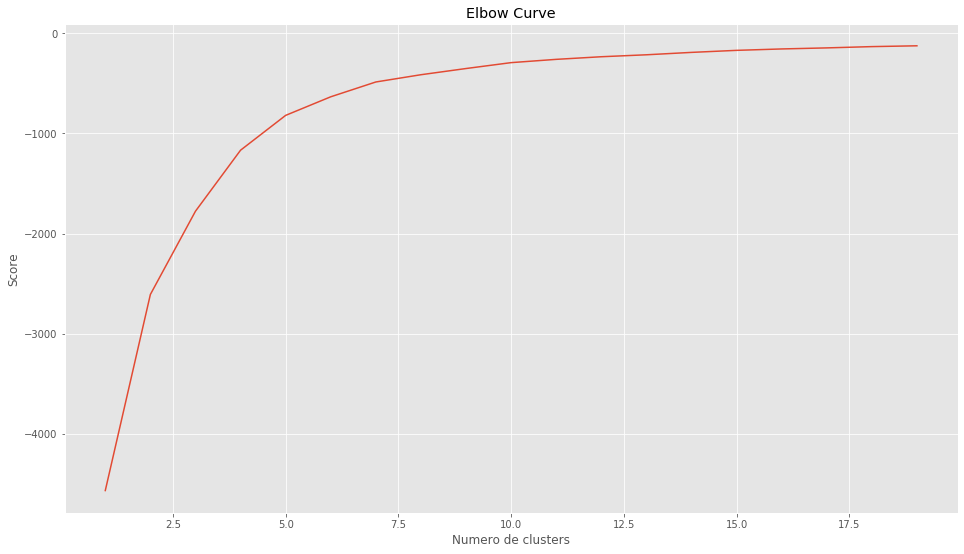

In [7]:
X = np.array(sdf)
Nc = range(1,20)
kmeans = [KMeans(n_clusters=i) for i in Nc]

score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]

plt.rcParams['figure.figsize'] = (16, 9)
plt.plot(Nc, score)
plt.xlabel('Numero de clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [8]:
n=5

In [9]:
kmeans = KMeans(n_clusters=n).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[-0.17008231 -0.13375725 -0.29030675]
 [ 6.39460743 10.73617302  0.08108144]
 [ 4.04737031  1.90435663  0.1876102 ]
 [-0.35814317 -0.16174388  7.32857375]
 [-0.18113239 -0.13569971  1.26394892]]


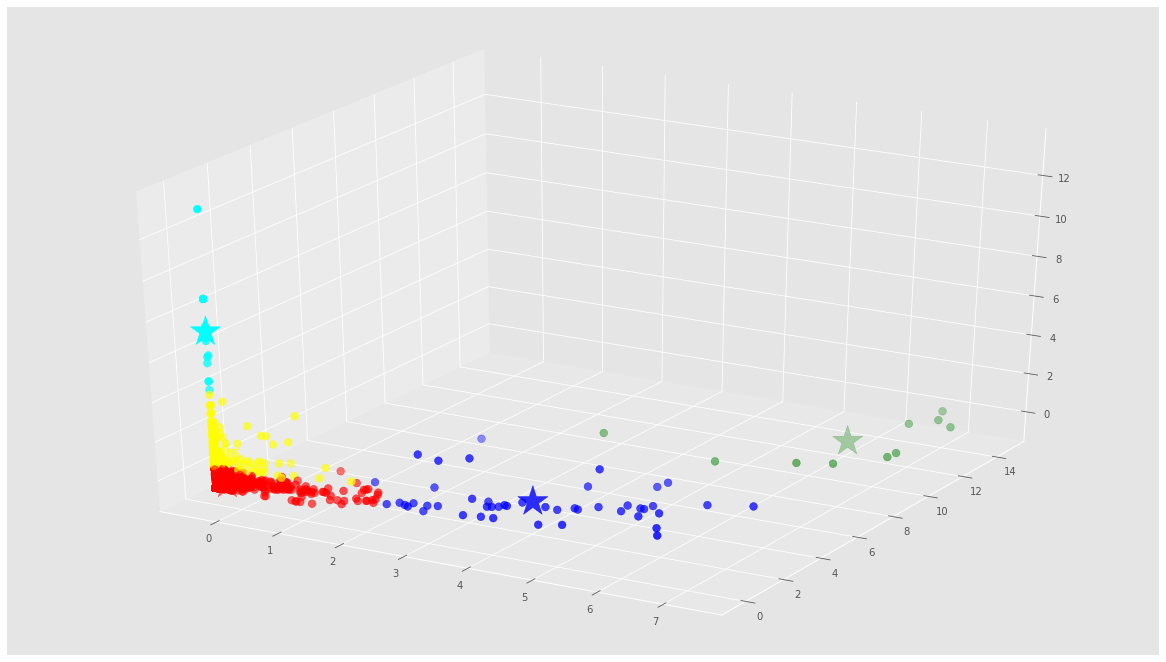

In [11]:
# Predicting the clusters
labels = kmeans.predict(X)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue','cyan','yellow']#,'brown','violet']
km=[]
for row in labels:
    km.append(colores[row])
 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=km,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)
plt.show()

## Gaussian Mixture Model

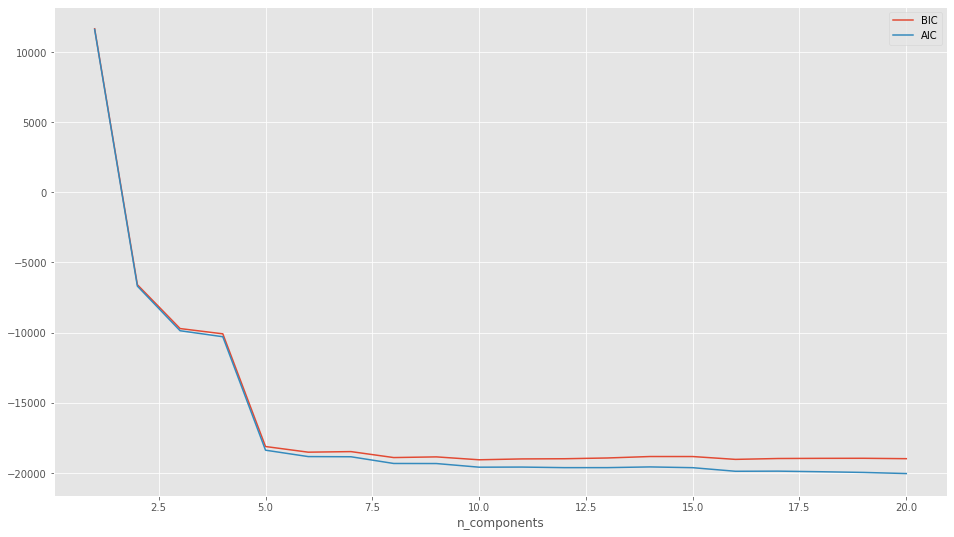

In [12]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(X)
          for n in n_components]

plt.plot(n_components, [m.bic(X) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [13]:
n=5

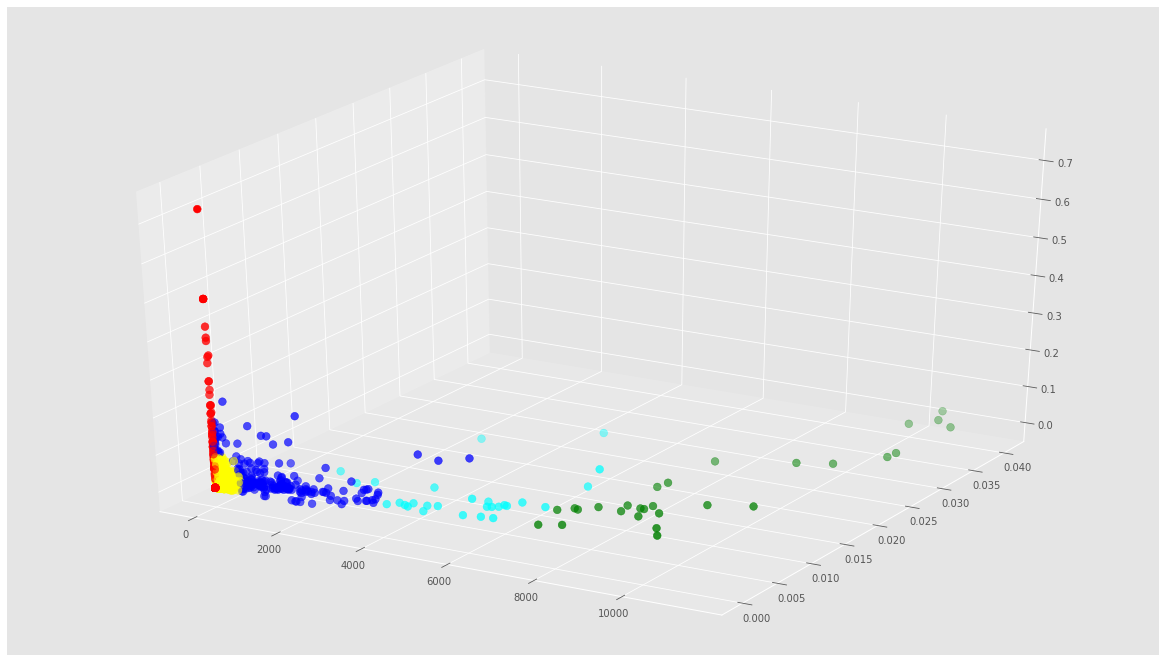

In [14]:

X = np.array(df)
#Predict GMM cluster membership
gm_labels = GaussianMixture(n_components=n, random_state=0).fit(X).predict(X)
cmap = 'tab10'

colores=['red','green','blue','cyan','yellow','brown','violet','black','lime','pink']
gm=[]
for row in gm_labels:
    gm.append(colores[row])
 
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=gm,s=60)
# ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)
plt.show()


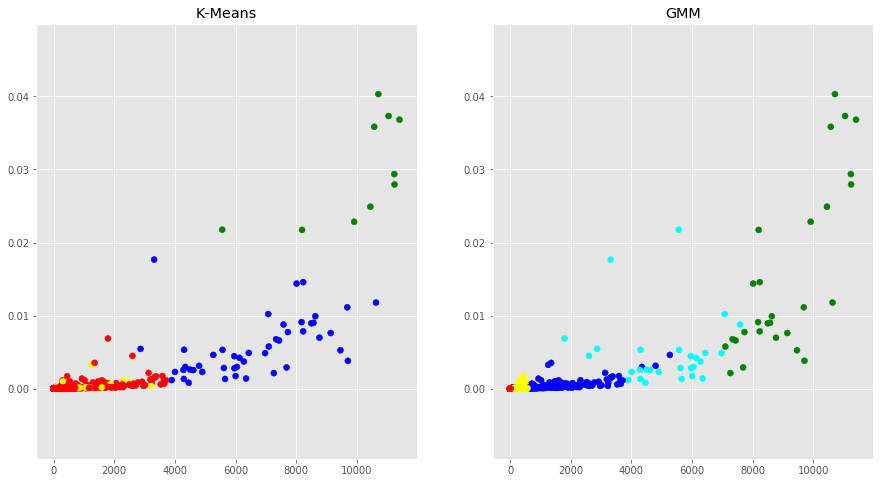

In [15]:

plt.figure(figsize=(15,8))
plt.subplot(121, title='K-Means')
plt.scatter(X[:,0], X[:,1], c=km, cmap=cmap)
plt.subplot(122, title='GMM')
plt.scatter(X[:,0], X[:,1], c=gm, cmap=cmap)
plt.show()

In [16]:
print(np.bincount(labels))
print(np.bincount(gm_labels))

[1253   10   47   14  199]
[548  28 243  28 676]


In [17]:
# df['km'] = labels
df['gm'] = gm_labels

print(probs.shape)
print(df.shape)
probs = pd.merge(probs, df[['gm']], how='left', right_index=True, left_index=True)
# probs['km'] = probs['km'].replace(np.nan,n)
probs['gm'] = probs['gm'].replace(np.nan,n)

print(probs.shape)
probs.head()

(1725, 7)
(1523, 4)
(1725, 8)


,conversion+1,user_count,freq,proportion,prob1,ord1,PAGE_descripcion,gm
PAGE,,,,,,,,
1,5638.0,8013,257914,0.014379,0.021860,195.0,WEB : EMINENT,1.0
2,98465.0,11642,2935681,0.163667,0.033541,389.0,/LOGIN,5.0
3,99669.0,11578,2838128,0.158228,0.035118,418.0,/INICIO,5.0
4,16283.0,11234,526725,0.029365,0.030914,351.0,/CUENTAS/MIS-CUENTAS,1.0
5,21648.0,11405,660189,0.036806,0.032791,379.0,/ERROR/SESIONEXPIRADA,1.0


In [18]:
probs[['gm','PAGE_descripcion']].groupby(['gm']).nunique()

,gm,PAGE_descripcion
gm,,
0.0,1,548
1.0,1,28
2.0,1,243
3.0,1,28
4.0,1,676
5.0,1,202


In [19]:
probs[['PAGE_descripcion','gm']].to_csv('page_group.csv',sep=',',header=True)